<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/Decision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2023-02-27 03:53:09--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 104.18.11.128, 104.18.10.128, 2606:4700::6812:a80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.11.128|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2023-02-27 03:53:10--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2023-02-27 03:53:10--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting r

In [ ]:
!pip install stable-baselines3
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=555e5434f0bb9010c8e565dc1e6825d0ff1cc7c00a98483f1166353b5b529641
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.0.0
    Uninstalling importlib-metadata-6.0.0:
      Successfully uninstalled importlib-metadata-6.0.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
%load_ext cython

In [ ]:
import numpy as np
import pandas as pd
import gym
import talib as ta
import matplotlib.pyplot as plt
import random
import math
import time
import cython
import itertools
import sys

import scipy
from sklearn.preprocessing import MinMaxScaler
from scipy import fftpack, signal

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, QuantileTransformer
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.optim import Adam
from collections import deque, namedtuple

In [ ]:
class MarketData:
    @classmethod
    def initialize(cls, terms, sampling_window, data_length):
        st = time.time()
        cls.terms = terms
        cls.sampling_window = sampling_window
        cls.data_length = data_length
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
        cls.log_ohlc = {} #term1:list, terms2:list....
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.williams_R = {}
        cls.macd = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.stochastic = {}
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.__calc_index()
        cls.all_index = {}
        #cls.__calc_all_index()

        cls.sampled_ts = []
        cls.std = []
        cls.skew = []
        cls.kurtosis = []
        cls.mean = []
        cls.median = []
        cls.mode = []
        cls.max_min_ratio = []
        cls.total_change_ratio = []
        cls.period_change_ratio = []
        cls.max_end_ratio = []
        cls.min_end_ratio = []
        cls.sampled_data = []
        #cls.__get_sampling_data()
        print('Completed Market Data, time=', time.time() - st)
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])

    @classmethod
    def __calc_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.williams_R[term] = cls.__calc_williams_R(term)
            cls.macd[term] = cls.__calc_macdfix(term)
            cls.aroon_os[term] = cls.__calc_aroon_os(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.stochastic[term] = cls.__calc_stochastic(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.adxr[term] = cls.__calc_adxr(term)
            cls.apo[term] = cls.__calc_apo(term)
            cls.plus_minus_di[term] = cls.__calc_plus_minus_di(term)
            cls.ppo[term] = cls.__calc_ppo(term)
            cls.ultosc[term] = cls.__calc_ultosc(term)

    #sklearn minmax scalerよりもこっちの方が少しだけ早い
    @classmethod
    def __minmax_scaler(cls, data):
        data_min = np.min(data)
        data_max = np.max(data)
        data_scaled = (data - data_min) / (data_max - data_min)
        return data_scaled

    @classmethod
    def __data_sampler(cls, current_ind:int, term:int, num_nn_units:int):
        sampling_rate = int(term / num_nn_units)
        sampling_indices = np.arange(current_ind - term, current_ind, sampling_rate)
        return np.array(MarketData.logclose)[sampling_indices]

    @classmethod
    def get_nn_input(cls, current_ind:int, num_nn_units:int, short_term:int, mid_term1:int, mid_term2:int, long_term1:int, long_term2:int):
        short_data = cls.__data_sampler(current_ind, short_term, num_nn_units)
        mid_data1 = cls.__data_sampler(current_ind, mid_term1, num_nn_units)
        mid_data2 = cls.__data_sampler(current_ind, mid_term2, num_nn_units)
        long_data1 = cls.__data_sampler(current_ind, long_term1, num_nn_units)
        long_data2 = cls.__data_sampler(current_ind, long_term2, num_nn_units)
        rsi = [MarketData.rsi[x][current_ind] for x in list(MarketData.rsi.keys())]
        res = [cls.__minmax_scaler(short_data), cls.__minmax_scaler(mid_data1), cls.__minmax_scaler(mid_data2), cls.__minmax_scaler(long_data1), cls.__minmax_scaler(long_data2)]
        return np.array(list(np.array(res).flatten()) + list(rsi))

    @classmethod
    def get_ohlc(cls, index:int):
        return [cls.open[index], cls.high[index], cls.low[index], cls.close[index]]

    @classmethod
    def __calc_all_index(cls):
        for term in cls.terms:
            cls.all_index['ma_kairi_'+str(term)] = cls.__calc_ma_kairi(term)
            cls.all_index['rsi_'+str(term)] = cls.__calc_rsi(term)
            cls.all_index['williams_R_'+str(term)] = cls.__calc_williams_R(term)
            cls.all_index['macd_'+str(term)] = cls.__calc_macdfix(term)
            cls.all_index['aroon_os_'+str(term)] = cls.__calc_aroon_os(term)
            cls.all_index['cci_'+str(term)] = cls.__calc_cci(term)
            cls.all_index['dx_'+str(term)] = cls.__calc_dx(term)
            cls.all_index['stochastic_'+str(term)] = cls.__calc_stochastic(term)
            cls.all_index['cmo_'+str(term)] = cls.__calc_cmo(term)
            cls.all_index['adxr_'+str(term)] = cls.__calc_adxr(term)
            cls.all_index['apo_'+str(term)] = cls.__calc_apo(term)
            cls.all_index['di_'+str(term)] = cls.__calc_plus_minus_di(term)
            cls.all_index['ppo_'+str(term)] = cls.__calc_ppo(term)
            cls.all_index['ultosc_'+str(term)] = cls.__calc_ultosc(term)

    #initialize index after obtained converted data for NN input
    @classmethod
    def initialize_index_data(cls):
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.williams_R = {}
        cls.macd = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.stochastic = {}
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.all_index = {}

    @classmethod
    def __get_sampling_data(cls):
        count = 0
        current_start = 0
        while True:
            data = cls.close[current_start : current_start + cls.data_length]
            change_ratio = data / np.roll(data, 1)
            change_ratio = change_ratio[1:]
            maxv = max(data)
            minv = min(data)
            cls.sampled_ts.append(cls.ts[current_start + cls.data_length - 1])
            cls.mean.append(np.mean(change_ratio))
            cls.std.append(np.std(change_ratio))
            cls.skew.append(scipy.stats.skew(change_ratio))
            cls.kurtosis.append(scipy.stats.kurtosis(change_ratio))
            cls.mode.append(scipy.stats.mode(change_ratio)[0][0])
            cls.max_min_ratio.append(maxv / minv)
            cls.period_change_ratio.append(data[-1] / data[0])
            cls.total_change_ratio.append(100 * np.mean(np.diff(data) / np.mean(data)))
            cls.max_end_ratio.append(data[-1] / maxv)
            cls.max_end_ratio.append(data[-1] / minv)
            current_start += cls.sampling_window
            if current_start + cls.data_length >= len(cls.close):
                break
        for i in range(len(cls.sampled_ts)):
            cls.sampled_data.append([cls.mean[i], cls.std[i], cls.skew[i], cls.kurtosis[i], cls.mode[i], cls.max_min_ratio[i],
                                     cls.period_change_ratio[i], cls.total_change_ratio[i], cls.max_end_ratio[i],
                                     cls.max_end_ratio[i]])


    @classmethod
    def __calc_ma_kairi(cls, term):
        ma = list(ta.MA(np.array(cls.close, dtype='f8'), timeperiod=term))
        return list(map(lambda c, e: (c - e) / e, np.array(cls.close, dtype='f8'), np.array(ma, dtype='f8')))
    
    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.logclose, dtype='f8'), timeperiod=term) / 100.0
    
    @classmethod
    def __calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'),timeperiod=term))
        
    @classmethod
    def __calc_macdfix(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.logclose, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd

    @classmethod
    def __calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_cci(cls, term):
        return list(ta.CCI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_dx(cls, term):
        return list(ta.DX(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_stochastic(cls, term):
        k_term = term
        d_term = int(term / 2.0)
        fastk, fastd = ta.STOCHF(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), fastk_period=k_term, fastd_period=d_term, fastd_matype=0)
        return list(np.array(fastk) / np.array(fastd))


    @classmethod
    def __calc_cmo(cls, term):
        return list(ta.CMO(np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_adxr(cls, term):
        return ta.ADXR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_apo(cls, term):
        fperiod=term
        speriod=term * 2
        return ta.APO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_plus_minus_di(cls, term):
        mdi = ta.MINUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        pdi = ta.PLUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        return list(np.array(mdi) / np.array(pdi))

    @classmethod
    def __calc_ppo(cls, term):
        fperiod = term
        speriod = term * 2
        return ta.PPO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_ultosc(cls, term):
        p2 = int(term / 2.0)
        p1 = int(term / 3.0)
        return ta.ULTOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod1=p1, timeperiod2=p2, timeperiod3=term)

sampling_window = 1
data_length = 60
MarketData.initialize([5, 60, 240, 1440, 10080], sampling_window, data_length)

<ipython-input-7-7eabf6196015>:219: RuntimeWarning: invalid value encountered in true_divide
  return list(np.array(fastk) / np.array(fastd))


Completed Market Data, time= 72.21759104728699


In [ ]:
################################################################################
################################ Convert Market Data #################################
################################################################################
'''
class MarketDataConverter:
    def start(self, corr_kijun:float):
        self.corr_kijun = corr_kijun
        all_target_keys = self.select_low_corr()
        all_converted_data = self.convert_data(all_target_keys)
        return all_converted_data

    def select_low_corr(self):
        #set all index keys
        all_index_keys = {}
        target_all_index = []
        for key in list(MarketData.all_index.keys()):
            all_index_keys[key] = True
            target_all_index.append(key)
        #check corr with close price
        price_corr = {}
        num_removed_high_price_corr = 0
        for key in list(MarketData.all_index.keys()):
            price_corr[key] = np.corrcoef(MarketData.all_index[key][1000:], MarketData.logclose[1000:])
            if abs(price_corr[key][0][1]) >= self.corr_kijun:
                all_index_keys[key] = False
                target_all_index.remove(key)
                num_removed_high_price_corr += 1
        print('Removed ', num_removed_high_price_corr, ' index correlated with price.')
        #remove all highly correlated index
        target_index = ''
        checked_key = []
        for k in all_index_keys.keys():
            if all_index_keys[key] == True:
                target_index = key
                break
        df = pd.DataFrame(MarketData.all_index)
        df_corr = df.corr()
        num_removed_high_index_corr = 0
        while True:
            checked_key.append(target_index)
            for col in df_corr.columns:
                if target_index != col and all_index_keys[col] == True:
                    if abs(df_corr[col][target_index]) >= self.corr_kijun:
                        all_index_keys[col] = False
                        num_removed_high_index_corr += 1
                        target_all_index.remove(col)
            if len(set(checked_key) ^ set(target_all_index)) > 0:
                sabun = list(set(checked_key) ^ set(target_all_index))
                target_index = random.choice(sabun)
            else:
                break
        print('Removed ', num_removed_high_index_corr, '  index correlated with other index.')
        return all_index_keys
            
    def convert_data(self, all_target_keys:list):
        converted_all_index = {}
        for k in all_target_keys:
            sorted_list = sorted(MarketData.all_index[k])
            maxv = sorted_list[int(-len(MarketData.all_index[k]) * 0.01)]
            minv = sorted_list[int(-len(MarketData.all_index[k]) * 0.99)]
            con = []
            for v in MarketData.all_index[k]:
                if v >= maxv or v <= minv:
                    v = min(max(v, maxv),minv)
                con.append(v)
            con = np.array(con).reshape(-1,1)
            scaler = MinMaxScaler()
            scaler.fit(con)
            data_scaled = scaler.transform(con)
            converted_all_index[k] = data_scaled
        return converted_all_index

mdc = MarketDataConverter()
con_marketdata = mdc.start(0.8)
MarketData.initialize_index_data()
'''

"\nclass MarketDataConverter:\n    def start(self, corr_kijun:float):\n        self.corr_kijun = corr_kijun\n        all_target_keys = self.select_low_corr()\n        all_converted_data = self.convert_data(all_target_keys)\n        return all_converted_data\n\n    def select_low_corr(self):\n        #set all index keys\n        all_index_keys = {}\n        target_all_index = []\n        for key in list(MarketData.all_index.keys()):\n            all_index_keys[key] = True\n            target_all_index.append(key)\n        #check corr with close price\n        price_corr = {}\n        num_removed_high_price_corr = 0\n        for key in list(MarketData.all_index.keys()):\n            price_corr[key] = np.corrcoef(MarketData.all_index[key][1000:], MarketData.logclose[1000:])\n            if abs(price_corr[key][0][1]) >= self.corr_kijun:\n                all_index_keys[key] = False\n                target_all_index.remove(key)\n                num_removed_high_price_corr += 1\n        print

In [111]:
################################################################################
################################ Trading Environment #################################
################################################################################
%%cython -a
import numpy as np
import random
import itertools
cimport numpy as cnp

cdef class AccountEnv:
    #Asset, fee,
    cdef public double is_done_pnl_ratio
    cdef public double cash
    cdef public double default_cash
    cdef public double market_order_fee
    cdef public double limit_order_fee    
    cdef public int duration
    cdef public int order_distribution_num
    cdef public double min_holding_size

    #holding
    cdef public int holding_side
    cdef public double holding_price
    cdef public double holding_size
    cdef public double holding_amount
    cdef public int holding_period


    #order
    cdef public list buy_orders
    cdef public list sell_orders
    cdef public list pt_orders
    cdef public dict lc_order
    cdef public list order_ids
    cdef public int order_id_last
    cdef public double buy_order_ratio_start
    cdef public double buy_order_ratio_end
    cdef public double sell_order_ratio_start
    cdef public double sell_order_ratio_end
    cdef public int buy_order_dist_type
    cdef public int sell_order_dist_type
    cdef public double pt_ratio_start
    cdef public double pt_ratio_end
    cdef public double lc_ratio
    cdef public list pt_ids
    cdef public int pt_id_last

    #performance
    cdef public double realized_pnl
    cdef public double unrealized_pnl
    cdef public double total_pnl
    cdef public double pre_entry_total_pnl
    cdef public double total_fee
    cdef public int num_trade #holding sideが変わった時にカウント
    cdef public int num_win #holding sideが変わった時のtotal_pnlをpre_entry_total_pnlに記録して次にsideが変わった時のtotal_pnlと増減でカウント
    cdef public double win_rate

    
    #log
    cdef public list log_total_pnl
    cdef public list log_close_price

    #params for state
    cdef public double state_scaler_min #to rescale order price divergence, unrealized pnl ratio, -0.1
    cdef public double state_scaler_max #0.1
    cdef public int state_scaler_bin

    #for RFL
    cdef public double reward
    cdef public dict state
    cdef public int is_done #0:false, 1:true

    #state
    cdef public int state_length
    cdef public list state_holding_buy_side
    cdef public list state_holding_sell_side
    cdef public list state_holding_size_percentage
    cdef public list state_holding_sell_size_percentage
    cdef public list state_buy_order_size_percentage
    cdef public list state_sell_order_size_percentage
    cdef public list state_pt_order
    cdef public list state_lc_order
    cdef public list state_buy_order_divergence #3%を上限とした乖離率
    cdef public list state_sell_order_divergence #3%を上限とした乖離率
    cdef public list state_pt_order_divergence
    cdef public list state_lc_order_divergence
    cdef public list state_unrealized_pnl #-5% - +5%の範囲で0-1に変換
    cdef public double order_divergence_kijun
    cdef public double unrealized_pnl_kijun
    

    
    '''
    save: デバッグ中。market closeでそもそもかなり小さなsizeの時にその10%のorder出せるのがOKかは微妙。一定以下の保有になるexit orderの場合はfull exit扱いにしたほうがいい。

    ・agentは時刻tのohlcで判断する。ENVはt+1のohlcで約定判断等する。
    ・order, pt/lcがある状態で注文を入れても無効扱いとなる。（既存のorderキャンセルして新しい注文を優先させるようにもできる）
    ・ptは複数のlimit orderとして出す。1 pt order当たりのsizeは常にholding size / 残っているpt order数
    ・entryは毎回同じ金額の保有を想定して行う。 （limit orderは追加で入れることができない仕様　＋　entry時のサイズはdefault cashの値を基準に計算）

    stete:
    各種データの時系列配列
    position_buy, position_sell, position_size /default_cash, order

    pt_ratio_start = 0.01 - 0.05 (should be largar than limit order fee)
    pt_ratio_end = 0.01 - 0.05 (it actually limit order price width)
    lc_ratio = 0.01 - 0.1
    order_ratio_start = 0.001 - 0.05
    order_ratio_end = 0.01 - 0.05 (it actually limit order price width, start ratio + end ratio)
    '''
    def __cinit__(self, is_done_pnl_ratio:double, order_distribution_num, market_order_fee:double, limit_order_fee:double, state_length:int):
        #trading settings
        self.default_cash = 10000 #always 
        self.order_distribution_num = order_distribution_num
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.market_order_fee = market_order_fee #0.006
        self.limit_order_fee = limit_order_fee #0.001
        self.min_holding_size = 0.01 #minimum percentage of holding size per default_cash, it should treat as full exit if holding size after exec of exit order fall below this value

        #params for state generation
        self.state_length = state_length
        self.order_divergence_kijun = 0.03
        self.unrealized_pnl_kijun = 0.05
        self.reset()



        #state
    cpdef void __initialize_state(self):        
        self.state_holding_buy_side = [0] * self.state_length
        self.state_holding_sell_side = [0] * self.state_length
        self.state_holding_size_percentage = [0] * self.state_length
        self.state_buy_order_size_percentage = [0] * self.state_length
        self.state_sell_order_size_percentage = [0] * self.state_length
        self.state_pt_order = [0] * self.state_length
        self.state_lc_order = [0] * self.state_length
        self.state_buy_order_divergence = [1] * self.state_length
        self.state_sell_order_divergence = [1] * self.state_length
        self.state_pt_order_divergence = [1] * self.state_length
        self.state_lc_order_divergence = [1] * self.state_length
        self.state_unrealized_pnl = [0] * self.state_length

        


    cpdef tuple reset(self):
        self.cash = self.default_cash
        self.realized_pnl = 0 #cash base
        self.unrealized_pnl = 0 #cash base
        self.pre_entry_total_pnl = 0
        self.total_pnl = 0
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0
        self.total_fee = 0
        self.duration = 0
        self.log_total_pnl = []
        self.log_close_price = []
        self.__initialize_holding()
        self.__initialize_order()
        self.__initialize_state()
        self.is_done = self.__check_is_done()
        self.reward = self.__calc_reward()
        self.state = self.__generate_state([0,0,0,0])
        return (self.state, self.reward, self.is_done)

    '''
    無効な行動した場合は-1
    order cancelしてpt, lc残っていたら-1

    '''
    cpdef int __calc_reward(self):
        if len(self.log_total_pnl) > 2:
            if self.log_total_pnl[-1] == self.log_total_pnl[-2]:
                return 0
            elif self.log_total_pnl[-1] > self.log_total_pnl[-2]:
                return 1
            else:
                return -1
        else:
            return 0


    cpdef dict __generate_state(self, list ohlc_t1):
        self.state_holding_buy_side.append(1 if self.holding_side == 1 else 0)
        self.state_holding_sell_side.append(1 if self.holding_side == -1 else 0)
        self.state_holding_size_percentage.append(0 if self.holding_side ==0 else round(self.holding_size * ohlc_t1[-1] / self.default_cash,4))
        self.state_buy_order_size_percentage.append(0 if len(self.buy_orders) == 0 else round(sum([d['price'] * d['size'] for d in self.buy_orders]) / self.default_cash, 4))
        self.state_sell_order_size_percentage.append(0 if len(self.sell_orders) == 0 else round(sum([d['price'] * d['size'] for d in self.sell_orders]) / self.default_cash, 4))
        self.state_pt_order.append(0 if len(self.pt_orders) == 0 else 1)
        self.state_lc_order.append(0 if len(self.lc_order) == 0 else 1)
        self.state_buy_order_divergence.append(1 if len(self.buy_orders) == 0 else max(round(((ohlc_t1[2] - self.buy_orders[0]['price']) / self.buy_orders[0]['price']) / self.order_divergence_kijun, 4), 1.0))
        self.state_sell_order_divergence.append(1 if len(self.sell_orders) == 0 else max(round(((self.sell_orders[0]['price'] - ohlc_t1[1]) / self.sell_orders[0]['price']) / self.order_divergence_kijun, 4), 1.0))
        self.state_pt_order_divergence.append(1 if len(self.pt_orders) == 0 else max(round( (self.pt_orders[0]['ratio'] + (self.holding_side * (self.holding_price - ohlc_t1[-1]) / self.holding_price)) / self.order_divergence_kijun, 4), 1.0))
        self.state_lc_order_divergence.append(1 if len(self.lc_order) == 0 else max(round( (self.lc_order['ratio'] + (self.holding_side * (self.holding_price - ohlc_t1[-1]) / self.holding_price)) / self.order_divergence_kijun, 4), 1.0))
        self.state_unrealized_pnl.append(0 if self.unrealized_pnl < (-self.unrealized_pnl_kijun * self.default_cash) else 1 if self.unrealized_pnl > (self.unrealized_pnl_kijun * self.default_cash) else self.unrealized_pnl / self.default_cash)
        #state用のデータが一定以上の長さになったら一部削除する
        if len(self.state_holding_buy_side) > self.state_length * 2.1:
            del self.state_holding_buy_side[0:self.state_length]
            del self.state_holding_sell_side[0:self.state_length]
            del self.state_holding_size_percentage[0:self.state_length]
            del self.state_buy_order_size_percentage[0:self.state_length]
            del self.state_sell_order_size_percentage[0:self.state_length]
            del self.state_pt_order[0:self.state_length]
            del self.state_lc_order[0:self.state_length]
            del self.state_buy_order_divergence[0:self.state_length]
            del self.state_sell_order_divergence[0:self.state_length]
            del self.state_pt_order_divergence[0:self.state_length]
            del self.state_lc_order_divergence[0:self.state_length]
            del self.state_unrealized_pnl[0:self.state_length]
        return {'state_holding_buy_side':self.state_holding_buy_side,
                'state_holding_sell_side':self.state_holding_sell_side,
                'state_holding_size_percentage':self.state_holding_size_percentage,
                'state_buy_order_size_percentage':self.state_buy_order_size_percentage,
                'state_sell_order_size_percentage':self.state_sell_order_size_percentage,
                'state_pt_order':self.state_pt_order,
                'state_lc_order':self.state_lc_order,
                'state_buy_order_divergence':self.state_buy_order_divergence,
                'state_sell_order_divergence':self.state_sell_order_divergence,
                'state_pt_order_divergence':self.state_pt_order_divergence,
                'state_lc_order_divergence':self.state_lc_order_divergence,
                'state_unrealized_pnl':self.state_unrealized_pnl}


    #-0.05から0.05の範囲の値をいい感じに10の01に変換する間数、使ってない。
    '''
    cpdef cnp.ndarray generate_input_array(self, double unrealized_pnl):
        unrealized_pnl = 0.05 if unrealized_pnl > 0.05 else -0.05 if unrealized_pnl < -0.05 else unrealized_pnl
        kizami = (0.05 - (-0.05)) / 10
        index = int((v + 0.05) / kizami)
        result = [0] * 10
        result[:index] = [1] * index
        if index < 10:
            result[index] = (unrealized_pnl + 0.05 - kizami * index) / kizami
        return result
    '''

    cpdef cnp.ndarray __scale_data(self, double actual_v):
        return np.histogram([actual_v], bins=self.state_scaler_bin, range=(self.state_scaler_min, self.state_scaler_max))[0]
        

    cpdef void __initialize_order(self):
        self.buy_orders = [] #{'id', 'price', 'size', 'ratio'} *side:1 or -1, size:actual BTC vol, ratio:percentage (0-1)
        self.sell_orders = [] #{'id', 'price', 'size', 'ratio'} *side:1 or -1, size:actual BTC vol, ratio:percentage (0-1)
        self.buy_order_dist_type = -1 #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        self.sell_order_dist_type = -1 #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        self.order_ids = [] #start from 0
        self.order_id_last = 0
        self.pt_orders = [] #{'status', 'id', 'side', 'pt ratio'} 、サイズは全て同じ（holding_size / num_pt_orders)
        self.lc_order = {} #{'side', 'lc ratio'}
        self.pt_ids = [] #start from 0
        self.pt_id_last = 0


    cpdef void __initialize_holding(self):
        self.cash = self.default_cash
        self.holding_side = 0 
        self.holding_price = 0
        self.holding_size = 0
        self.holding_amount = 0
        self.holding_period = 0
    
    cpdef void __update_holding(self, int side, double price, double size):
        if self.holding_side != side:
            self.holding_period = 0
            if self.holding_side != 0: #現在ポジション持っていてexit、opposite entryした場合は勝ち負け判定して現時点のtotal pnlを記録
                if self.pre_entry_total_pnl < self.total_pnl:
                    self.num_win += 1
                self.pre_entry_total_pnl = self.total_pnl
                self.num_trade += 1
        self.holding_side = side
        self.holding_price = price
        self.holding_size = size
        self.holding_amount = size * price
    

    cpdef tuple action_space_sample(self):
        action_id = random.randint(0,10)
        order_dist_type = random.randint(0, 4)
        order_price_start_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        order_price_width_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        pt_price_start_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        pt_price_width_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        num_pt_div = random.randint(2, 10)
        lc_ratio = random.randint(5, 50) / 1000.0 #0.005 - 0.05
        market_close_ratio = random.randint(10, 100) / 100.0
        action = (action_id, order_dist_type, order_price_start_ratio, order_price_width_ratio, pt_price_start_ratio, pt_price_width_ratio, num_pt_div, lc_ratio, market_close_ratio)
        return action

    '''
    price_start_ratio, price_end_ratio: i.e. start = 0.01, end = 0.01, current price= 10000 then order = [10100, 10120,,,, 10201]
    '''
    cpdef tuple step(self, int action, int order_dist_type, double order_price_start_ratio, double order_price_width_ratio, double pt_price_start_ratio, double pt_price_width_ratio, int num_pt_div, double lc_ratio, double market_close_ratio, list ohlc_t1):
        #action = 0:nothing, 1:buy, 2:sell, 3:pt, 4:lc, 5:cancel buy, 6:cancel sell, 7:cancel pt, 8:cancel lc, 9:cancel all, 10: market close (percentage)
        #Buy: price start ratio,  price end ratio= (0.01 - 0.05)
        #Sell: price start ratio,  price end ratio= (0.01 - 0.05)
        #pt_ratio = (0.01 - 0.05)
        #lc_ratio = (0.005 - 0.05)
        #market_close_ratio = (0.1 - 1)
        #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        if self.holding_side == 0 and len(self.buy_orders) == 0 and action == 1:#entry buy limit order
            self.__entry_order(1, 1, order_price_start_ratio, order_price_width_ratio, order_dist_type, ohlc_t1)
        elif self.holding_side == 0 and len(self.sell_orders) == 0 and action == 2:#entry sell limit order
            self.__entry_order(1, -1, order_price_start_ratio, order_price_width_ratio, order_dist_type, ohlc_t1) 
        elif self.holding_side != 0  and len(self.pt_orders) == 0 and action == 3:#place pt order
            self.__entry_pt_order(pt_price_start_ratio, pt_price_width_ratio)
        elif self.holding_side != 0 and  len(self.lc_order) == 0 and action == 4: #place lc order
            self.__entry_lc_order(lc_ratio)
        elif len(self.buy_orders) > 0 and action == 5:#cancel buy
            self.__cancel_order(1)
        elif len(self.sell_orders) > 0 and action == 6:#cancel sell
            self.__cancel_order(-1)
        elif len(self.pt_orders) > 0 and action == 7: #cancel pt
            self.pt_orders = []
            print('Cancelled PT Orders')
        elif len(self.lc_order) > 0 and action == 8: #cancel lc
            self.lc_order = {}
            print('Cancelled LC Order')
        elif len(self.lc_order) > 0 and action == 9: #cancel all
            self.__cancel_order(1)
            self.__cancel_order(-1)
            self.pt_orders = []
            self.lc_order = {}
            print('Cancelled PT Orders')
            print('Cancelled LC Order')
        elif self.holding_side != 0 and action == 10: #market close
            self.__entry_market_order(1 if self.holding_side == -1 else -1, market_close_ratio, ohlc_t1)
        self.__check__execution(ohlc_t1)
        self.__update_performance(ohlc_t1)
        self.__take_log(ohlc_t1)
        self.duration += 1
        self.is_done = self.__check_is_done()
        self.reward = self.__calc_reward()
        self.state = self.__generate_state(ohlc_t1)
        return (self.state, self.reward, self.is_done, 0)
    

    '''
    otype should be always 1 as limit order.
    market order is allowed only for exit_all, and stop loss market order
    {'id', 'price', 'size', 'ratio'}
    '''
    cpdef void __entry_order(self, int otype, int side, double price_start_ratio, double price_width_ratio, int order_dist_type, list ohlc_t1):
        order_prices = self.__generate_order_prices(side, price_start_ratio, price_width_ratio, ohlc_t1[0])
        order_percentage_ditribution = self.__generate_order_percentage(order_dist_type, order_prices)
        order_size_distribution = self.__generate_order_size(order_percentage_ditribution, ohlc_t1[0])
        if side == 1:
            self.buy_order_dist_type = order_dist_type
            for i in range(len(order_prices)):
                self.buy_orders.append({'id':self.order_id_last, 'price':order_prices[i], 'size':order_size_distribution[i], 'ratio':order_percentage_ditribution[i]})
                self.order_ids.append(self.order_id_last)
                self.order_id_last += 1
            print('Entry Buy Order: ', self.buy_orders)
        else:
            self.sell_order_dist_type = order_dist_type
            for i in range(len(order_percentage_ditribution)):
                self.sell_orders.append({'id':self.order_id_last, 'price':order_prices[i], 'size':order_size_distribution[i], 'ratio':order_percentage_ditribution[i]})
                self.order_ids.append(self.order_id_last)
                self.order_id_last += 1
            print('Entry Sell Order: ', self.sell_orders)
        
        
    '''
    market order should be immediaterly executed
    executed at open price (most recent avaialble price post bot decision)
    size should be provided as a percentage of current holding size
    '''
    cpdef void __entry_market_order(self, int side, double percentage, list ohlc_t1):
        if self.holding_size > 0:
            if self.holding_side != side:
                print('Entry Market Order: side=', side, ', percent=', percentage)
                self.__process_execution(0, side, round(self.holding_size * percentage, 4), ohlc_t1[0])
            else:
                print('AccountEnv: market order is not available for same side of current holding !')    
        else:
            print('AccountEnv: market order is not available when no holding !')


    '''
    #{'id', 'status', 'side', 'ratio'} 
    '''
    cpdef void __entry_pt_order(self, double pt_price_start_ratio, double pt_price_width_ratio):
        side = 1 if self.holding_side == -1 else -1
        pt_ratio = self.__generate_pt_ratio(pt_price_start_ratio, pt_price_width_ratio)                
        for i in range(len(pt_ratio)):
            self.pt_orders.append({'id':self.pt_id_last, 'status':'active', 'side':side, 'ratio':pt_ratio[i]})
            self.pt_ids.append(self.pt_id_last)
            self.pt_id_last += 1
        print('Entry PT Order: ', self.pt_orders)

    '''
    {'side', 'ratio'}
    '''
    cpdef void __entry_lc_order(self, double lc_ratio):
        side = 1 if self.holding_side == -1 else -1
        self.lc_order = {'side':side, 'ratio':lc_ratio}
        print('Entry LC Order: ', self.lc_order)


    cpdef bint __check_is_done(self):
        if self.is_done_pnl_ratio <= (self.realized_pnl + self.unrealized_pnl - self.total_fee) / self.default_cash:
            return False
        else:
            return True

    

    cpdef void __take_log(self, list ohlc_t1):
        self.log_total_pnl.append(self.total_pnl)
        self.log_close_price.append(ohlc_t1[-1])


    '''
    order price listからdistribution typeに対応したorder sizeの現在のcashに応じたpercentageを算出。
    percentage list * order priceの合計値が現在のcashになる。
    '''
    cpdef cnp.ndarray __generate_order_percentage(self, int order_dist_type, cnp.ndarray prices):
        order_size_ditribution = np.zeros(1)
        if order_dist_type == 0: #uniform distribution
            order_size_ditribution = np.round(1.0/self.order_distribution_num * self.default_cash / prices, 4)
        elif order_dist_type == 1: #y=x
            order_size_ditribution = np.linspace(1, self.order_distribution_num+1, self.order_distribution_num)
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        elif order_dist_type == 2: #y=-x
            order_size_ditribution = np.linspace(self.order_distribution_num+1, 1, self.order_distribution_num)
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        elif order_dist_type == 3: #/\
            order_size_ditribution = np.concatenate([np.linspace(1, self.order_distribution_num+1, int(self.order_distribution_num * 0.5)), 
                                                     np.linspace(self.order_distribution_num+2, 1, self.order_distribution_num - int(self.order_distribution_num * 0.5))])
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        elif order_dist_type == 4: #\/
            order_size_ditribution = np.concatenate([np.linspace(self.order_distribution_num+1, 1, int(self.order_distribution_num * 0.5)), 
                                                     np.linspace(2, self.order_distribution_num+1, self.order_distribution_num - int(self.order_distribution_num * 0.5))])
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        return order_size_ditribution


    '''
    (1+start_ratio) * price ~ (1 + width_ratio) * start_priceの一定間隔の任意数の価格リストを計算
    '''
    cpdef cnp.ndarray __generate_order_prices(self, int oside, double price_start_ratio, double price_width_ratio, double current_price):
        if oside == -1:
            s = (1.0 + price_start_ratio) * current_price
            e = (1.0 + price_width_ratio) * s
            return np.round(np.linspace(s, e, self.order_distribution_num), 2)
        else:
            s = (1.0 - price_start_ratio) * current_price
            e = (1.0 - price_width_ratio) * s
            return np.round(np.linspace(s, e, self.order_distribution_num), 2)
    
    '''
    order percentage listとorder price listから実際に板に載るorder size listを計算する。
    order size list * order priceの合計が現在のcashになる。
    '''
    cpdef cnp.ndarray __generate_order_size(self, cnp.ndarray order_ratio, double current_price):
        ratio = order_ratio / np.sum(order_ratio)
        return np.round((self.default_cash * ratio) / current_price, 4)

    cpdef cnp.ndarray __generate_pt_ratio(self, double start_ratio, double width_ratio):
        return np.round(np.linspace(start_ratio, start_ratio + width_ratio, self.order_distribution_num), 4)

    cpdef void __cancel_order(self, int side):
        if side == 1:
            self.buy_orders = []
            print('Cancelled Buy Orders')
        elif side == -1:
            self.sell_orders = []
            print('Cancelled Sell Orders')
        else:
            print('AccountEnv: Invalid side in cancel order !')

    '''
    limit orderのentryはopen, 陽線陰線でhigh/lowの順番を決める。high/lowにおける約定判定のみでopen, closeは判定しなくても良い。
    0: no execution, 1:buy order exec, 2:sell order exec, 3:pt exec, 4:lc exec, 5:multiple exec
    '''
    cpdef cnp.ndarray __check__execution(self, ohlc_t1):
        executions = []
        check_prices = []
        if ohlc_t1[3] > ohlc_t1[0]: #yosen
            check_prices = [ohlc_t1[2], ohlc_t1[1]]
        else:
            check_prices = [ohlc_t1[1], ohlc_t1[2]]
        for p in check_prices:
            lc_price = self.__check_lc_execution(p) #check lc
            if lc_price > 0:
                self.__process_lc_order(lc_price)
                executions.append(4)
                break
            pt_price, pt_ind = self.__check_pt_execution(p) #check pt
            if pt_price > 0:
                print('pt price=', pt_price)
                self.__process_pt_order(pt_price, pt_ind)
                executions.append(3)
            for order in self.buy_orders[:]:
                if order['price'] > p:
                    self.__process_execution(1, 1, order['size'], order['price'])
                    executions.append(1)
                else:
                    break #no need to check other orders as order[0] should most close to current price
            for order in self.sell_orders[:]:
                if order['price'] < p:
                    self.__process_execution(1, -1, order['size'], order['price'])
                    executions.append(2)
                else:
                    break #no need to check other orders as order[0] should most close to current price
        return np.array(executions)


    cpdef tuple __check_pt_execution(self, double market_price):
        if len(self.pt_orders) > 0:
            if self.holding_side == 1:
                pt_price = round((1.0 + self.pt_orders[0]['ratio']) * self.holding_price, 2)
                if market_price > pt_price:                    
                    return (pt_price, 0)
                else:
                    return (-1, -1)
            elif self.holding_side == -1:
                pt_price = round((1.0 - self.pt_orders[0]['ratio']) * self.holding_price, 2)
                if market_price < pt_price:
                    return (pt_price, 0)
                else:
                    return (-1, -1)
        else:
            return (-1, -1)

    
    cpdef double __check_lc_execution(self, market_price):
        if len(self.lc_order) > 0:
            if self.holding_side == 1:
                lc_price = round((1.0 - self.lc_order['ratio']) * self.holding_price, 2)
                if market_price <= lc_price:
                    return lc_price
            elif self.holding_side == -1:
                lc_price = round((1.0 + self.lc_order['ratio']) * self.holding_price, 2)
                if market_price >= lc_price:
                    return lc_price
            else:
                return -1
        else:
            return -1
                
    
    '''
    market orderはbuy/sell_ordersに入れずに直接即時約定される。
    '''
    cpdef void __process_execution(self, int otype, int oside, double size, double exec_price):
        fee = self.__calc_fee(otype, size, exec_price)
        self.total_fee += fee
        if self.holding_side == 0: #new entry
            print('New Entry Execution: side=', oside, ', size=', size, ', price=', exec_price)
            self.cash -= (size * exec_price) - fee
            self.__update_holding(oside, exec_price, size)
            if otype != 0:
                self.__remove_order(oside)
        elif self.holding_side != oside: #exit
            if abs( self.holding_price * (self.holding_size - size) / self.default_cash) <= self.min_holding_size: #fully exit
                print('Full Exit: side=', oside, ', size=', self.holding_size, ', price=', exec_price)
                self.cash += (self.holding_size * exec_price) - fee
                realized_pnl = self.__calc_realized_pnl(self.holding_size, exec_price)
                self.realized_pnl += realized_pnl
                self.__update_holding(0, 0, 0)
                self.__initialize_order()
            elif self.holding_size > size:
                print('Partial Exit: side=', oside, ', size=', size, ', price=', exec_price)
                self.cash += (size * exec_price) - fee
                realized_pnl = self.__calc_realized_pnl(size, exec_price)
                self.realized_pnl += realized_pnl
                self.__update_holding(oside, exec_price, self.holding_size - size)
                if otype != 0:
                    self.__remove_order(oside)
            else: #exit & opposite entry
                print('Exit & Opposite Entry: side=', oside, ', size=', size, ', price=', exec_price)
                self.cash = self.default_cash - ((size - self.holding_size) * exec_price)
                realized_pnl = self.__calc_realized_pnl(size, exec_price)
                self.realized_pnl += realized_pnl
                self.__update_holding(oside, exec_price, size - self.holding_size)
                if otype != 0:
                    self.__remove_order(oside)
                #print('AccountEnv: exit and opposite entry is not allowed !')
        else: #additional entry
            print('Additional Entry: side=', oside, ', size=', size, ', price=', exec_price)
            self.cash -= (size * exec_price) - fee
            updated_price = (self.holding_size * self.holding_price + size * exec_price) / (self.holding_size + size)
            self.__update_holding(oside, updated_price, self.holding_size + size)
            if otype != 0:
                self.__remove_order(oside)

    '''
    Assumed buy/sell order is always in A-Z order and executed from A
    '''
    cpdef void __remove_order(self, int oside):
        if oside == 1:
            del self.buy_orders[0]
            if len(self.buy_orders) == 0:
                self.buy_order_dist_type = -1
                self.buy_orders = []
        else:
            del self.sell_orders[0]
            if len(self.sell_orders) == 0:
                self.sell_order_dist_type = -1
                self.sell_orders = []

    cpdef void __process_pt_order(self, double pt_exec_price, int pt_order_ind):
        pt_exec_size = self.holding_size / len(self.pt_orders)
        if abs( self.holding_price * (self.holding_size - pt_exec_size) / self.default_cash) <= self.min_holding_size: #full exit pt
            pt_exec_size = self.holding_size
        fee = self.__calc_fee(1, pt_exec_size, pt_exec_price)
        self.total_fee += fee
        self.cash += (pt_exec_size * pt_exec_price) - fee
        realized_pnl = self.__calc_realized_pnl(pt_exec_size, pt_exec_price)
        self.realized_pnl += realized_pnl
        if pt_exec_size == self.holding_size:
            self.__update_holding(0, 0, 0)
            self.__initialize_order()
        else:
            self.__update_holding(self.holding_side, self.holding_price, self.holding_size - pt_exec_size)
            del self.pt_orders[pt_order_ind]
            if len(self.pt_orders) == 0:
                self.__initialize_order()
        print('pt executed at ', pt_exec_price, ' x', pt_exec_size, ', pnl=', realized_pnl)
        

    cpdef void __process_lc_order(self, double lc_price):
        fee = self.__calc_fee(0, self.holding_size, lc_price)
        self.total_fee += fee
        self.cash += (lc_price * self.holding_size) - fee
        realized_pnl = self.__calc_realized_pnl(self.holding_size, lc_price)
        self.realized_pnl += realized_pnl
        self.__update_holding(0, 0, 0)
        self.__initialize_order()
        print('lc executed at ', lc_price, ', pnl=', realized_pnl)
        
    
    cpdef double __calc_fee(self, int otype, double size, double exec_price):
        if otype == 0:
            return self.market_order_fee * size * exec_price
        elif otype == 1:
            return self.limit_order_fee * size * exec_price


    cpdef double __calc_realized_pnl(self, double size, double exec_price):
        if exec_price != self.holding_price:
            return self.holding_side * (exec_price - self.holding_price) * size
        else:
            return 0


    cpdef void __update_performance(self, list ohlc_t1):
        if self.num_trade > 0:
            self.win_rate = self.num_win / self.num_trade
        if self.holding_side != 0:
            self.unrealized_pnl = self.holding_side * (ohlc_t1[-1] - self.holding_price) * self.holding_size
        else:
            self.unrealized_pnl = 0
        self.total_pnl = self.realized_pnl + self.unrealized_pnl - self.total_fee




In [ ]:
################################################################################
############################# Test Trading Environment ##############################
################################################################################
'''
market closeでそもそもかなり小さなsizeの時にその10%のorder出せるのがOKかは微妙。一定以下の保有になるexit orderの場合はfull exit扱いにしたほうがいい。

・ランダムアクションのトレードを行いエラーが発生しないこと
・pt, lcが正常に機能すること
・market close orderが正常に機能すること
'''
is_done_pnl_ratio = -0.1
order_distribution_num = 10
market_order_fee = 0.006
limit_order_fee = 0.001
state_length = 120
start_ind = 1000000


env = AccountEnv(is_done_pnl_ratio, order_distribution_num, market_order_fee, limit_order_fee, state_length)
env.reset()
for i in range(50000):
    action = env.action_space_sample()
    actionz = action[0]
    if action[0] == 5 or action[0] == 6:
        actionz = 0
    ohlc = MarketData.get_ohlc(i + start_ind)
    #int action, int order_dist_type, double order_price_start_ratio, double order_price_width_ratio, double pt_price_start_ratio, double pt_price_width_ratio, int num_pt_div, double lc_ratio, double market_close_ratio, list ohlc_t1
    state, reward, is_done, _ = env.step(actionz, action[1], action[2], action[3], action[4], action[5], action[6], action[7], action[8], ohlc)
    if env.holding_side !=0:
        print('i=',i, 'p=',ohlc[-1], 'holding side=', env.holding_side, ', holding size=', env.holding_size, ', holding price=', env.holding_price, ', pnl=', env.total_pnl, ', num trade=', env.num_trade, 'win rate=', env.win_rate, 'realized pnl=', env.realized_pnl, 'unrealized pnl=', env.unrealized_pnl)
    if is_done:
        print('i=',i, ', done')
        break
print('total pnl=', env.total_pnl, 'num trade=', env.num_trade, ', win rate=', env.win_rate)
plt.plot(env.log_total_pnl)

Entry Buy Order:  [{'id': 0, 'price': 31925.34, 'size': 0.0525, 'ratio': 0.0551}, {'id': 1, 'price': 31790.54, 'size': 0.0408, 'ratio': 0.0428}, {'id': 2, 'price': 31655.75, 'size': 0.0289, 'ratio': 0.0303}, {'id': 3, 'price': 31520.95, 'size': 0.017, 'ratio': 0.0178}, {'id': 4, 'price': 31386.16, 'size': 0.0049, 'ratio': 0.0051}, {'id': 5, 'price': 31251.36, 'size': 0.0097, 'ratio': 0.0102}, {'id': 6, 'price': 31116.56, 'size': 0.0209, 'ratio': 0.0219}, {'id': 7, 'price': 30981.77, 'size': 0.032, 'ratio': 0.0336}, {'id': 8, 'price': 30846.97, 'size': 0.0433, 'ratio': 0.0454}, {'id': 9, 'price': 30712.18, 'size': 0.0546, 'ratio': 0.0573}]
Entry Sell Order:  [{'id': 10, 'price': 34161.1, 'size': 0.0049, 'ratio': 0.0047}, {'id': 11, 'price': 34271.18, 'size': 0.017, 'ratio': 0.0163}, {'id': 12, 'price': 34381.25, 'size': 0.0291, 'ratio': 0.0279}, {'id': 13, 'price': 34491.32, 'size': 0.0411, 'ratio': 0.0394}, {'id': 14, 'price': 34601.4, 'size': 0.053, 'ratio': 0.0509}, {'id': 15, 'price

In [98]:
env.holding_price

0.0

In [ ]:
################################################################################
################################ Positional Encoder #################################
################################################################################
class PositionalEncoder:
    def getPositionEncoding(self, seq_len, dim, n):
        p = np.zeros((seq_len, dim))
        for k in range(seq_len):
            for i in np.arange(int(dim/2)):
                denominator = np.power(n, 2*i/dim)
                p[k, 2*i] = np.sin(k/denominator)
                p[k, 2*i+1] = np.cos(k/denominator)
        return p

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

'''
t = torch.tensor(con_marketdata[list(con_marketdata.keys())[0]])
pe = PositionalEncoding(t.shape[0])
pe(t)
'''

In [ ]:
################################################################################
################################ Embedding Input #################################
################################################################################
is_done_pnl_ratio = -0.1
market_order_fee = 0.01
limit_order_fee = 0.006
order_distribution_num = 10
ptlc_ratio_start = 0.01
ptlc_ratio_end = 0.05
order_ratio_start = 0.005
order_ratio_end = 0.05


class InputEmbedding:
    def generate_initia_data(self, start_ind:int, num_length:int, env, market_index_data:dict):
        initial_embd_data = []
        state, reward, is_done = env.reset()
        for i in range(num_length):
            action = env.action_space_sample()
            ohlc = [MarketData.open[start_ind+i], MarketData.high[start_ind+i], MarketData.low[start_ind+i], MarketData.close[start_ind+i]]
            state, reward, is_done, _ = env.step(0, action[1], action[2], action[3], action[4], action[5], ohlc) #fix action type = none
            con_state = np.array(list(itertools.chain(*state.values())))
            con_action = np.concatenate([np.eye(1, M=8, k=action[0])[0], np.eye(1, M=4, k=action[1])[0], [action[2],action[3],action[4]]])
            combined = np.concatenate([con_state, con_action])
            combined = np.append(combined, np.array(reward))
            md = []
            for k in list(market_index_data.keys()):
                md.append(market_index_data[k][start_ind][0])
            initial_embd_data.append(np.concatenate([combined, np.array(md)]))
        return initial_embd_data

    def generate_embedded_input(self, market_data_ind:int, state:dict, action:dict, reward:float, market_index_data:dict):
        ohlc = [MarketData.open[market_data_ind], MarketData.high[market_data_ind], MarketData.low[market_data_ind], MarketData.close[market_data_ind]]
        con_state = np.concatenate([np.array(list(state.values())[0]), np.array(list(state.values())[1:]).flatten()])
        con_action = np.concatenate([np.eye(1, M=8, k=action[0])[0], np.eye(1, M=4, k=action[1])[0], [action[2],action[3],action[4]]])
        combined = np.concatenate([con_state, con_action])
        combined = np.append(combined, np.array(reward))
        md = []
        for k in list(market_index_data.keys()):
            md.append(market_index_data[k][market_data_ind][0])
        return np.concatenate([combined, np.array(md)])
        

#ac = AccountEnv(is_done_pnl_ratio, market_order_fee, limit_order_fee, order_distribution_num, ptlc_ratio_start, ptlc_ratio_end, order_ratio_start, order_ratio_end)
input_embedding = InputEmbedding()
#initial_embd_data = input_embedding.generate_initia_data(100000, 10, ac, con_marketdata)

action = ac.action_space_sample()
ohlc = [MarketData.open[100000], MarketData.high[100000], MarketData.low[100000], MarketData.close[100000]]
state, reward, is_done, _ = ac.step(action[0], action[1], action[2], action[3], action[4], action[5], ohlc)
next_embd_data = input_embedding.generate_embedded_input(100000, state, action, reward, con_marketdata)

In [ ]:
################################################################################
################################ Data Standardization #################################
################################################################################
class DataStandardization:
    def standardScaler(self):
        standardized_data = {}
        sc = StandardScaler()
        for key in list(MarketData.index_data.keys()):
            standardized_data[key] = sc.fit_transform(np.array(MarketData.index_data[key]).reshape(-1,1)).flatten()
        return pd.DataFrame.from_dict(standardized_data)

    def minmaxScalerMarketData(self, df, from_ind, to_ind):
        scaled_data = {}
        ms = MinMaxScaler()
        for col in df.columns:
            scaled_data[col] = ms.fit_transform(np.array(df[col]).reshape(-1,1)).flatten()
        return pd.DataFrame.from_dict(scaled_data)

    def minmaxScalerAction(self, data, from_ind, to_ind):
        scaled_data = {}
        ms = MinMaxScaler((-1, 1))
        return ms.fit_transform(np.array(data[from_ind:to_ind+1]).reshape(-1,1)).flatten()


'''        
ds = DataStandardization()
sdf = ds.standardScaler()
for col in sdf:
    plt.figure()
    plt.title(col)
    plt.plot(sdf[col])
plt.show()
'''

In [ ]:
'''
is_done_pnl_ratio = -0.1
market_order_fee = 0.01
limit_order_fee = 0.006
order_distribution_num = 10
ptlc_ratio_start = 0.01
ptlc_ratio_end = 0.05
order_ratio_start = 0.005
order_ratio_end = 0.05

ac = AccountEnv(is_done_pnl_ratio, market_order_fee, limit_order_fee, order_distribution_num, ptlc_ratio_start, ptlc_ratio_end, order_ratio_start, order_ratio_end)
ac.reset()
start_ind = 1000000
st = time.time()
for i in range(1000):
    ohlc = [MarketData.open[start_ind + i], MarketData.high[start_ind + i],MarketData.low[start_ind + i],MarketData.close[start_ind + i]]
    action = ac.action_space_sample()
    res = ac.step(action[0], action[1], action[2], action[3], action[4], action[5], ohlc)
    print('i=', res[0])
    #print('i=',i, 'close=',ohlc[3], 'side=',ac.position['side'], ', size=', ac.position['size'], ', price=',  ac.position['price'], ', reward=', res[2],  ', unrealized_pnl=', ac.unrealized_pnl, ', total pnl=', ac.realized_pnl + ac.unrealized_pnl - ac.total_fee)
print('num trade=', ac.num_trade, ', win rate=', ac.win_rate, ', pnl=', ac.realized_pnl + ac.unrealized_pnl - ac.total_fee)
print('time=', time.time()-st)
'''

In [ ]:
################################################################################
################################ Replay Memory #################################
################################################################################
Transition = namedtuple('Transition',
                        ('market_data', 'state', 'action', 'log_probs', 'reward', 'state_value'))

class ReplayMemory:
    @classmethod
    def initialize(cls, capacity):
        cls.memory = deque([], maxlen=capacity)

    @classmethod
    def push(cls, *args):
        cls.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
################################################################################
################################ network #################################
################################################################################
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, inputs_shape, num_heads, dropout_ratio, device, dtype):
        #super(Transformer, self).__init__()
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=inputs_shape[-1], num_heads=num_heads, dropout=dropout_ratio, device = device, dtype = dtype)
        self.norm1 = nn.LayerNorm(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.linear1 = nn.Linear(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.softplus1 = nn.Softplus()
        self.linear2 = nn.Linear(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.softplus2 = nn.Softplus()
        self.do1 = nn.Dropout(p=dropout_ratio)
        self.norm2 = nn.LayerNorm(inputs_shape[-1], device = device, dtype = dtype)

    def forward(self, inputs):
        output = self.mha(inputs, inputs, inputs)
        output_norm = self.norm1(output[0] + inputs)
        output = self.linear1(output_norm)
        output = self.softplus1(output[0])
        output = self.linear2(output)
        output = self.do1(output)
        output = self.norm2(output + output_norm)
        return output


class Actor(nn.Module):
    def __init__(self, inputs_shape, outputs_shape, num_heads, dropout_ratio, device, dtype):
        #super(Bert, self).__init__()
        super().__init__()
        self.transformer1 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer2 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer3 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer4 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer5 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer6 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.flatten1 = nn.Flatten()
        self.linear1 = nn.Linear(inputs_shape[-1] * inputs_shape[-2], outputs_shape[-1], device = device, dtype = dtype)
        

    def forward(self, inputs):
        output = self.transformer1(inputs)
        output = self.transformer2(output)
        output = self.transformer3(output)
        output = self.transformer4(output)
        output = self.transformer5(output)
        output = self.transformer6(output)
        output = self.flatten1(output)
        output = self.linear1(output)
        return output



time= 0.09108538150787354


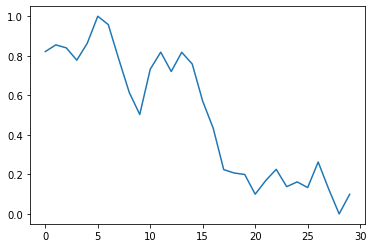

In [ ]:
####################################################################################
############################### Test Code ####################################
####################################################################################
current_ind = 1000000
term = 129600
nn_input_units = 30
scaler = MinMaxScaler()

st = time.time()

def minmax_scaler(data):
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)
    return data_scaled

for i in range(100):
    sampling_rate = int(term / nn_input_units)
    sampling_indices = np.arange(current_ind - term, current_ind, sampling_rate)
    sampled_data = np.array(MarketData.close)[sampling_indices]

    scaler.fit(sampled_data.reshape(-1,1))
    data_scaled = scaler.transform(sampled_data.reshape(-1,1))
    #data_scaled = minmax_scaler(sampled_data)
print('time=', (time.time() - st) / 100)
plt.plot(data_scaled)

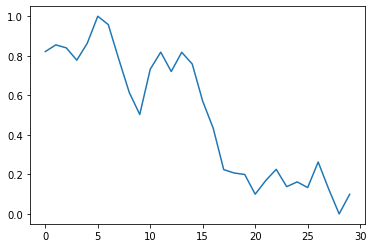

In [ ]:
plt.plot(data_scaled)

In [ ]:
####################################################################################
############################### Test Code ####################################
####################################################################################
data = MarketData.get_nn_input(1100000, 30, 60, 300, 3600, 14400, 129600)


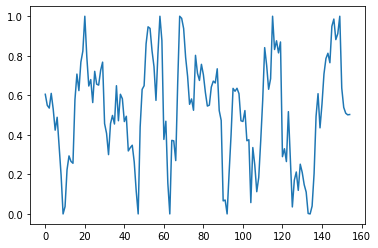

In [ ]:
plt.plot(data)

In [ ]:
np.array(data[0:-1]).flatten()

array([0.60516549, 0.54937006, 0.5354191 , 0.60981451, 0.5307686 ,
       0.42378131, 0.48890987, 0.34001774, 0.19568744, 0.        ,
       0.03728651, 0.22362933, 0.29346938, 0.26553588, 0.25622397,
       0.57726945, 0.70742233, 0.62376099, 0.76782568, 0.82356868,
       1.        , 0.79569886, 0.64700328, 0.67953857, 0.56332017,
       0.72136296, 0.65629954, 0.65165145, 0.72600965, 0.76782568,
       0.45687793, 0.40736048, 0.29999071, 0.45687793, 0.49812424,
       0.45481518, 0.64853286, 0.47131602, 0.60528719, 0.58262743,
       0.46719106, 0.49400035, 0.31858197, 0.33510472, 0.34749503,
       0.26279808, 0.11596236, 0.        , 0.44037477, 0.63000123,
       0.64853286, 0.8603793 , 0.94663802, 0.93842603, 0.82544445,
       0.74525486, 0.57438627, 0.81311166, 1.        , 0.87681512,
       0.37702873, 0.46890549, 0.15612264, 0.        , 0.37205266,
       0.36956425, 0.26982142, 0.66492079, 1.        , 0.98932435,
       0.93782227, 0.79245482, 0.696375  , 0.55451424, 0.58166

In [ ]:

data = np.zeros(1000)
d = [1]
st = time.time()
for i in range(100):
    d=list(data)
    np.array(d)
print(time.time() - st)

0.06349587440490723


In [ ]:
data[1]

array([0.45687793, 0.40736048, 0.29999071, 0.45687793, 0.49812424,
       0.45481518, 0.64853286, 0.47131602, 0.60528719, 0.58262743,
       0.46719106, 0.49400035, 0.31858197, 0.33510472, 0.34749503,
       0.26279808, 0.11596236, 0.        , 0.44037477, 0.63000123,
       0.64853286, 0.8603793 , 0.94663802, 0.93842603, 0.82544445,
       0.74525486, 0.57438627, 0.81311166, 1.        , 0.87681512])

In [ ]:
data[2]

array([0.37702873, 0.46890549, 0.15612264, 0.        , 0.37205266,
       0.36956425, 0.26982142, 0.66492079, 1.        , 0.98932435,
       0.93782227, 0.79245482, 0.696375  , 0.55451424, 0.58166878,
       0.52436238, 0.80223788, 0.71159623, 0.67524613, 0.7567137 ,
       0.70374128, 0.61470763, 0.5456208 , 0.55006792, 0.64179605,
       0.67180483, 0.66246174, 0.73416527, 0.52287856, 0.47287084])

In [ ]:
def generate_input_array(v):
    kizami = (0.05 - (-0.05)) / 10
    index = int((v + 0.05) / kizami)
    result = [0] * 10
    result[:index] = [1] * index
    if index < 10:
        result[index] = (v + 0.05 - kizami * index) / kizami
    return result

generate_input_array(0)

[1, 1, 1, 1, 1, 0.0, 0, 0, 0, 0]

In [ ]:
from IPython.terminal.shortcuts import previous_history_or_previous_completion
ratio = 0.01
side = 1
hp = 10000
cp = 9900

pt_price = (1+(side*ratio)) * hp
div = side * (pt_price - cp) / pt_price
print(pt_price)
print(div)

10100.0
0.019801980198019802


In [ ]:
(ratio + (hp - cp) *side / hp) / 0.03

0.6666666666666667

In [ ]:
import pandas as pd 
df = pd.read_csv('/content/drive/My Drive/okx-tickers.csv')
df['ticker'].iloc[0:5].to_list()

['BTC/USDT', 'ETH/USDT', 'OKB/USDT', 'OKT/USDT', 'LTC/USDT']

In [ ]:
import pandas as pd 
data = [{'ex_name':'binance', 'symbol':'BTC/USDT', 'bid':100, 'ask':200, 'average':110}, {'ex_name':'bybit', 'symbol':'BTC/USDT', 'bid':100, 'ask':200, 'average':110}, {'ex_name':'okx', 'symbol':'XRP/USDT', 'bid':100, 'ask':200, 'average':110}]
pd.DataFrame(data)

,ex_name,symbol,bid,ask,average
0,binance,BTC/USDT,100,200,110
1,bybit,BTC/USDT,100,200,110
2,okx,XRP/USDT,100,200,110


In [ ]:
d = {}
k = 'ts'
if k in d:
    d[k] += 1
else:
    d[k] = 0

In [ ]:
def test():
    return 0, -1
a, b = test()